# Ejemplo práctico de uso de diccionarios y for loops ( y gráficas).

## Comportamiento de neuronas.
Utilizando un modelo matemático (modelo de electrodifusión).
El modelo describe la actividad eléctrica de una neurona, al variar los distintos parámetros. <br />
Yo tengo un sistema de dos ecuaciones con varios parámetros, lo que quiero es tomar un parámetro y darle distintos valores y graficar la respuesta del sistema para cada valor del parámetro.<br />
<br />
Primero, la lista de los distintos parámetros que tengo y sus valores respectivos ¿A qué suena? <br />
Podría ser un diccionario, en el que las llaves son los nombres de mis parámetros y los valores, los valores asociados a cada parámetro.<br />
<br />
Ahora, ir cambiando el valor de cada parámetro en un rango escogido ¿A qué suena?<br />
<br />
...
<br />
Suena a un For loop!!!<br />



In [2]:
%matplotlib inline

Para construir un programa la primera parte es importar las librerias que se vayan a utlizar (en caso de que se necesite) <br />
<br />
Importamos matplotlib y pylab para las gráficas.<br />
Scipy para algunas funciones como la exponencial y los arreglos y para hacer la integral (odeint).

In [3]:
import matplotlib.pyplot as plt
import pylab as py
import scipy as sc
from scipy.integrate import odeint

#### Las ecuaciones diferenciales que vamos a utilizar.
$C \frac{dV}{dt} = I - I_{Na} - I_{K} - I_{L} $ <br />
<br />
$\frac{dW}{dt} = \frac{W_{Infty} - W}{\tau} $ <br />
<br />
Donde: <br />
<br />
$I_{Na} = \overline{g_{Na}}m_{Infty}^3(1-W)(V-V_{Na})$<br />
$I_{K} = \overline{g_{K}}(\frac{W}{S})^4(V-V_{K})$ <br />
$I_L = \overline{g_L}(V-V_L)$ <br />
<br />

Aquí muestro las ecuaciones que describen el sistema (la nuerona) que quiero modelar. <br />
La función rhs (Right Hand Side) utiliza los valores del diccionario (que aún no está definido) utilizando la sintaxis<br />
<br />
p['llave']<br />
<br />

Notar, lo que regresa esta función (su return) es:<br />
<br />
$\frac{dV}{dt}$ y $\frac{dW}{dt}$<br />
Dos ecuaciones diferenciales SIN RESOLVER.


In [4]:
def rhs(z,t,p):
    v, w = z
    winf = 1.0/(1.0+ sc.exp(-2*p['aw']*(v-p['V12w'])))
    minf = 1.0/(1.0+ sc.exp(-2*p['am']*(v-p['V12m'])))
    tauw = 1.0/(p['lambda']*sc.exp(p['aw']*(v-p['V12w']))+ p['lambda']*sc.exp(-p['aw']*(v-p['V12w'])))
    INa = p['gNa']*minf**p['mp']*(1-w)*(v-p['ENa'])
    IK = p['gK']*(w/p['s'])**p['wp']*(v-p['EK'])
    IL = p['gL']*(v-p['EL'])
    dvdt = (p['Istim'] - INa - IK - IL)/p['Cm']
    dwdt = (winf - w) / tauw
    return dvdt,dwdt

Creamos un diccionario vacío que se llama p <br />
Le agregamos los diferentes parámetros que necesitamos usando la siguiente sintaxis: <br />
<br />
p ['Llave'] = valor<br />
<br />
El nombre del diccionario, entre corchetes el nombre de la llave (en mi caso el nombre del parámetro) signo de igual y el valor (el valor podría ser una str también, sólo es necesario ponerlo entre comillas).<br />


In [5]:
p = {}
p['EK'] = -72.0
p['ENa']= 55.0 
p['EL']= -50.0 
p['gK']= 15.0 
p['gNa']= 120.0 
p['gL']= 0.3 
p['V12m']= -31.0
p['V12w']=-46.0
p['mp']= 3
p['wp']= 4
p['am']=0.065
p['aw']=0.055
p['lambda']= 0.08
p['Istim']= 0
p['s']= 1.0
p['Cm']=1.0
p['step'] = 0.001
p['tmin']= 0.0
p['tmax']= 100.0
p['sampTimes'] = sc.arange(p['tmin'],p['tmax'],p['step'])
p['w0']=0.005
p['v0']=-60
p['z0']= (p['v0'],p['w0'])
p['rhs']=rhs

Escribimos la función **solve**, esta función integra las dos ecuaciones diferenciales que describimos arriba ('rhs'), utilizando como condiciones iniciales los valores del diccionario w0 y V0 y el tiempo descrito en el diccionario como SampTimes

In [6]:
def solve (p):
    orbit =  sc.integrate.odeint(p['rhs'],p['z0'], p['sampTimes'],args=(p,)).transpose()
    vorbit = orbit[0]
    worbit = orbit[1]
    xx = {'v':vorbit, 'w':worbit, 'sampTimes':p['sampTimes']}
    return xx

Hasta ahora lo que hicimos fue definir las funciones que queremos resolver con valores de parámetros únicos (los dados en el diccionario) y resolver las ecuaciones utilizando una herramienta de scipy para integrar.<br />
<br />
Pero lo que yo quería hacer era resolver la ecuación para distintos valores de un mismo parámetros y luego graficar el comportamiento del sistema para poder visualizar las diferencias.<br />
<br />
Para esto creo una función que varíe los parámetros (paramVar)

In [7]:
def paramVars(pa, key = 'V12w', outString = r'$V12w$'):  
    vals = sc.arange(-50,-20,3)  # es un arreglo (como una lista) con los valores que voy a utlizar para el parámetro que escogí.
    simulations = list()  # es una lista vacía en la que se van a ir agregando las soluciones para cada valor del parámetro.
    nsims = len(vals)    # nsims nos da cuantos valores vamos a usar, cuantas veces vamos a resolver la ecuación.
    for n in sc.arange(nsims): # Creamos un for loop para cada uno de los valores en el arreglo que construimos arriba.
        p = pa.copy()   #Hacemos una copia del diccionario p sobre el cual vamos a variar el valor del parámetro.
        p[key] = vals[n]   # Cambiamos el valor del parámetro por el valor n de nuestro arreglo.
        #print('Performing simulations with %s=%g'%(key,p[key]))
        xx = solve(p)  # resolvemos las ecuaciones usando la función solve para el valor del parámetro n.
        simulations.append(xx)  # Agregamos la solución a la lista (antes vacía) 
        #Ahora tenemos una lista llamada 'simulations' en la que se encuentran las soluciones para cada uno de los valores n 
        # que tomó el parámetro que escogimos.
        #print simulations
         
    if 1:
        cols = 3; rows = sc.ceil(nsims/sc.float32(cols))
        fig = py.figure(figsize = (14,8)) #creamos una figura en la que van a estar las gráficas y le damos un tamaño.
        py.ioff() 
        ax = []  #Creamos una lista vacía 
        for n in sc.arange(nsims): #Creamos un for loop, que va a hacer una gráfica por cada valor n del parámetro.
            ax.append(fig.add_subplot(rows,cols,n+1))  #Agregamos a la lista un subplot una gráfica dentro de la figura.
            ax[n].plot(simulations[n]['sampTimes'], simulations[n]['v']) #Aquí le decimos que graficar en la figura que acaba de crear
            str1 = r'%s=%g'%(outString, vals[n]) 
            ax[n].set_ylim(-90,70)  # Le damos los límites del eje y 
            ax[n].set_xlabel('tiempo (ms)') # El nombre del eje x
            ax[n].set_ylabel('voltaje (mV)') # El nombre del eje y
            ax[n].text(0.6*p['tmax'], 50 , str1)
        py.ion(); py.draw() #Fuera del loop, le pedimos que enseñe lo que graficó en la la figura.
    return simulations

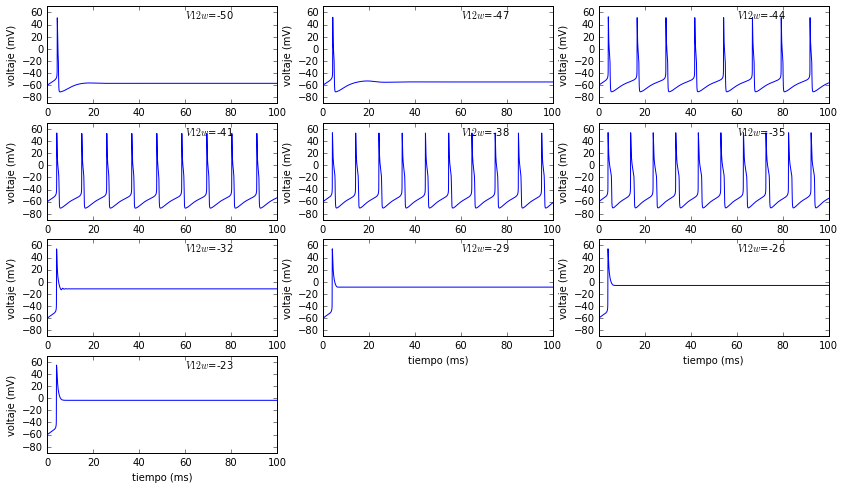

In [9]:
gKvar = paramVars(pa=p, key = 'V12w', outString = r'$V12w$')